In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss, InstanceHardnessThreshold, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

## 기본전처리

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd

# 데이터 불러오기
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

y = train['target']

train.drop(columns=['user_id', 'target'], axis=1, inplace=True)
test.drop(columns=['user_id'], axis=1, inplace=True)

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
# 중요한 변수 설정
important_variable = 'average_time_per_learning_session'

# 수치형 데이터 및 중요한 변수 분할
train_numeric_data = train[numerical_cols]
test_numeric_data = test[numerical_cols]


# 수치형 파이프라인 구성 (스케일링 및 PCA)
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

# 변환을 적용하는 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numerical_cols)
    ]
)

#레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전체 데이터 처리
train_numeric_processed_data = preprocessor.fit_transform(train)
test_numeric_processed_data = preprocessor.transform(test)

#스케일링된 중요한 변수들을 다시 DataFrame에 추가
scaler = StandardScaler()
train[important_variable] = scaler.fit_transform(train[important_variable].values.reshape(-1, 1))
test[important_variable] = scaler.transform(test[important_variable].values.reshape(-1, 1))

categorical_cols.append(important_variable)

train = pd.concat([
    pd.DataFrame(train_numeric_processed_data, columns=['pca1', 'pca2']),  # PCA 컬럼 이름 설정 필요
    train[categorical_cols]
], axis=1)

test = pd.concat([
    pd.DataFrame(test_numeric_processed_data, columns=['pca1', 'pca2']),  # PCA 컬럼 이름 설정 필요
    test[categorical_cols]
], axis=1)

train.head()

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)
X_train, y_train = OneSidedSelection().fit_resample(X_train, y_train)

counts = list(y_train.value_counts())

from sklearn.utils.class_weight import compute_class_weight 

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}
print(weights)


{0: 1.1411436082813013, 1: 0.8899282419272168}


# Drop 안한거 svc -> cat

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier
## standard scaler
weights_to_test = [(w1 * 0.1, w2 * 0.1, w3 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) for w3 in range(1, 10) if w1 + w2 + w3 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=8, iterations=500, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate='constant',  learning_rate_init=0.001, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

 67%|██████▋   | 24/36 [02:00<01:00,  5.04s/it]

max_weigth : (0.4, 0.30000000000000004, 0.30000000000000004), max_val : 0.520507639185112
              precision    recall  f1-score   support

           0       0.40      0.46      0.43       758
           1       0.64      0.59      0.61      1242

    accuracy                           0.54      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.55      0.54      0.54      2000



100%|██████████| 36/36 [03:00<00:00,  5.03s/it]


In [6]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=8, iterations=500, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate='constant',  learning_rate_init=0.001, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=42, subsample=0.5)
max_val = 0

for i in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                ('mp', mp)],
                                #('xgb', xgb)],
                                voting='soft',
                                weights=i
                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {i}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight

# (0.2, 0.8) 0.33 / 0.69
#
#

 89%|████████▉ | 8/9 [00:30<00:03,  3.77s/it]

max_weigth : (0.8, 0.2), max_val : 0.5254648450243864
              precision    recall  f1-score   support

           0       0.41      0.51      0.45       758
           1       0.65      0.55      0.60      1242

    accuracy                           0.54      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.56      0.54      0.54      2000



100%|██████████| 9/9 [00:34<00:00,  3.78s/it]


In [9]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.1, w2 * 0.1) for w1 in range(1, 10) for w2 in range(1, 10) if w1 + w2 == 10]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=8, iterations=500, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate='constant',  learning_rate_init=0.001, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [('cat', cat),
                                #('mp', mp)],
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight
# min : 0.5016342043444918
# sta : 0.5168004757656854

 33%|███▎      | 3/9 [00:13<00:27,  4.54s/it]

max_weigth : (0.30000000000000004, 0.7000000000000001), max_val : 0.5186430179583381
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       758
           1       0.64      0.58      0.61      1242

    accuracy                           0.53      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.55      0.53      0.54      2000



100%|██████████| 9/9 [00:39<00:00,  4.40s/it]


In [12]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

weights_to_test = [(w1 * 0.5, w2 * 0.5) for w1 in range(1, 20) for w2 in range(1, 20) if w1 + w2 == 20]
weights_to_test

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=8, iterations=500, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate='constant',  learning_rate_init=0.001, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=42, subsample=0.5)
max_val = 0

for weight in tqdm(weights_to_test):
    voting_model = VotingClassifier(estimators=
                                [#('cat', cat),
                                ('mp', mp),
                                ('xgb', xgb)],
                                voting='soft',
                                weights=weight

                                
                                )

    voting_model.fit(X_train, y_train)

    # 검증 데이터에서 성능 평가
    val_predictions = voting_model.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

    if val_f1 > max_val:
        clear_output(wait=True)
        print(f'max_weigth : {weight}, max_val : {val_f1}')
        print(classification_report(y_val, val_predictions, zero_division=0))
        max_val = val_f1
        max_weight = weight
# min : 0.5016342043444918
# sta : 0.5168004757656854

 16%|█▌        | 3/19 [00:05<00:29,  1.84s/it]

max_weigth : (1.5, 8.5), max_val : 0.5150866400145837
              precision    recall  f1-score   support

           0       0.40      0.45      0.42       758
           1       0.64      0.58      0.61      1242

    accuracy                           0.53      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.54      0.53      0.54      2000



100%|██████████| 19/19 [00:35<00:00,  1.87s/it]


In [11]:
X_train.head()

,pca1,pca2,preferred_difficulty_level,subscription_type,average_time_per_learning_session
0,0.028977,-0.278795,1,1,0.154226
1,0.077895,0.874575,1,1,-0.914812
2,0.356407,1.056478,1,1,-0.007198
3,0.344479,-0.403076,1,1,1.248365
4,-0.528107,2.615061,2,1,-0.831689


In [12]:
# 테스트 데이터에 대한 예측 수행
test_X = test.drop(columns=['user_id'])  # user_id는 제외하고 특성 데이터로 사용
test_predictions = voting_model.predict(test_X)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions
submit_path = f'./voting_model/voting(cat, xgb)2_tuned_model_drop(aban, ave, pay)_classweight.csv'
sample.to_csv(submit_path, index=False)


In [222]:
for i ,j in zip(X_train.columns, voting_model.feature_importances_):
    print(i,j)

subscription_duration 0.10698203
recent_login_time 0.10118902
average_time_per_learning_session 0.10923754
monthly_active_learning_days 0.099171825
total_completed_courses 0.09464165
recent_learning_achievement 0.10586606
community_engagement_level 0.10021998
preferred_difficulty_level 0.100718796
subscription_type 0.08933906
customer_inquiry_history 0.092634104


## 제출용

In [52]:
# 현재 최대 점수 !!! 0.5330428221
from sklearn.utils.class_weight import compute_class_weight
from catboost import  CatBoostClassifier
from sklearn.neural_network import MLPClassifier

train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

# train['recent_learning_achievement'] = train['recent_learning_achievement'].apply(lambda x :  train['recent_learning_achievement'].mean() if x  > 100 else x)
train['payment_pattern'] = train['recent_learning_achievement'].apply(lambda x: 'continuous' if x in [7, 5, 3, 1] else ('discontinuous' if x in [6, 4, 2] else 'Never'))
test['payment_pattern'] = test['recent_learning_achievement'].apply(lambda x: 'continuous' if x in [7, 5, 3, 1] else ('discontinuous' if x in [6, 4, 2] else 'Never'))

# test['recent_learning_achievement'] = test['recent_learning_achievement'].apply(lambda x :  train['recent_learning_achievement'].mean() if x  > 100 else x)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and col not in ['target']]
#numerical_cols.remove('payment_pattern')
categorical_cols = [col for col in train.columns if train[col].dtype == 'object' and col not in ['user_id']]
#categorical_cols.append('payment_pattern')
# 데이터 스케일링을 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 수치형 데이터에 대해 스케일링 적용
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# 레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전처리 후 학습 데이터 확인
train.head()

# 특성과 타겟 변수 분리
X = train.drop(columns=['user_id', 'target'])  # user_id는 제외하고 특성 데이터로 사용
y = train['target']

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 데이터를 기반으로 클래스 가중치 계산 
class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=6, iterations=700, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01, solver='adam', random_state=42)
xgb = XGBClassifier(learning_rate=1.0, max_depth=7, n_estimators=50, random_state=42, subsample=0.5)
max_val = 0


voting_model = VotingClassifier(estimators=
                            [('cat', cat),
                            ('mp', mp)],
                            #('xgb', xgb)],
                            voting='soft',
                            weights=[0.2, 0.8]

                            
                            )

voting_model.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = voting_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

print(f'max_val : {val_f1}')
print(classification_report(y_val, val_predictions, zero_division=0))

test.drop(columns=['user_id'], inplace=True, axis=1) 
test_predictions = voting_model.predict(test)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

# 리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
#submit_path = './voting(cat, mp)_drop(None)_nopreprocessing).csv'
#sample.to_csv(submit_path, index=False)

sample.head()

max_val : 0.49441982967414
              precision    recall  f1-score   support

           0       0.38      0.27      0.32       758
           1       0.62      0.73      0.67      1242

    accuracy                           0.56      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.53      0.56      0.54      2000



,user_id,target
0,0001d6e9,0
1,0002c77d,1
2,0002df5b,0
3,000b6068,1
4,00184a0c,1


In [47]:
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")
train[train['target']==0].mode()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,00030dc2,6.0,27.0,3.636424,0.011515,18.0,12.0,35.941755,3.0,5.0,Low,Basic,1.0,1.0,0.0
1,000a7fac,NaN,NaN,4.735407,0.012562,NaN,NaN,41.752942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001daa99,NaN,NaN,4.903691,0.017473,NaN,NaN,42.254863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0047ee1a,NaN,NaN,5.433492,0.029555,NaN,NaN,43.068185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,007855db,NaN,NaN,5.640182,0.045014,NaN,NaN,43.733914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,ffb25bdf,NaN,NaN,24.481035,174.327012,NaN,NaN,104.812784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3797,ffbed767,NaN,NaN,24.962679,174.562720,NaN,NaN,105.074082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3798,ffc7a476,NaN,NaN,25.279514,176.084277,NaN,NaN,106.385512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3799,ffcca840,NaN,NaN,25.815833,177.351455,NaN,NaN,106.942927,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
train[train['target']==1].mode()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,00058702,4.0,6.0,2.366189,0.013535,24.0,12.0,36.115562,2.0,5.0,Low,Basic,2.0,0.0,1.0
1,00076619,NaN,NaN,3.375170,0.035931,NaN,NaN,36.830979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00109fa1,NaN,NaN,3.483285,0.037657,NaN,NaN,42.430858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00153d57,NaN,NaN,3.970000,0.058419,NaN,NaN,42.870248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0025c0af,NaN,NaN,4.578543,0.060640,NaN,NaN,42.970217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6194,ff9a0d6e,NaN,NaN,25.100608,444.324058,NaN,NaN,106.102230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6195,ffb14cb4,NaN,NaN,25.271289,447.095844,NaN,NaN,108.127099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6196,ffe5da30,NaN,NaN,25.408557,470.289498,NaN,NaN,109.686851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6197,fff3144f,NaN,NaN,26.125596,490.233443,NaN,NaN,111.219647,NaN,NaN,NaN,NaN,NaN,NaN,NaN


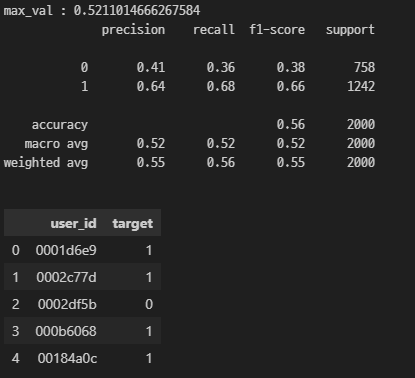

## pca 제출용

In [17]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd

# 데이터 불러오기
train = pd.read_csv("./data/train.csv", encoding="utf-8-sig")
test = pd.read_csv("./data/test.csv", encoding="utf-8-sig")
sample = pd.read_csv("./data/sample_submission.csv", encoding="utf-8-sig")

y = train['target']

train.drop(columns=['user_id', 'target'], axis=1, inplace=True)
test.drop(columns=['user_id'], axis=1, inplace=True)

# 수치형 및 범주형 변수 구분
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
# 중요한 변수 설정
important_variable = 'average_time_per_learning_session'

# 수치형 데이터 및 중요한 변수 분할
train_numeric_data = train[numerical_cols]
test_numeric_data = test[numerical_cols]


# 수치형 파이프라인 구성 (스케일링 및 PCA)
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

# 변환을 적용하는 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numerical_cols)
    ]
)

#레이블 인코딩을 위한 LabelEncoder 인스턴스 생성 및 적용
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    train[col] = label_encoders[col].fit_transform(train[col])
    test[col] = label_encoders[col].transform(test[col])

# 전체 데이터 처리
train_numeric_processed_data = preprocessor.fit_transform(train)
test_numeric_processed_data = preprocessor.transform(test)

#스케일링된 중요한 변수들을 다시 DataFrame에 추가
scaler = StandardScaler()
train[important_variable] = scaler.fit_transform(train[important_variable].values.reshape(-1, 1))
test[important_variable] = scaler.transform(test[important_variable].values.reshape(-1, 1))

categorical_cols.append(important_variable)

train = pd.concat([
    pd.DataFrame(train_numeric_processed_data, columns=['pca1', 'pca2']),  # PCA 컬럼 이름 설정 필요
    train[categorical_cols]
], axis=1)

test = pd.concat([
    pd.DataFrame(test_numeric_processed_data, columns=['pca1', 'pca2']),  # PCA 컬럼 이름 설정 필요
    test[categorical_cols]
], axis=1)

train.head()

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)
X_train, y_train = OneSidedSelection().fit_resample(X_train, y_train)

counts = list(y_train.value_counts())

from sklearn.utils.class_weight import compute_class_weight 

class_weight  = compute_class_weight( 'balanced' , classes=[ 0 , 1 ], y=y_train)
weights = {i: w for i, w in enumerate(class_weight)}

cat = CatBoostClassifier(depth=8, iterations=500, learning_rate=0.1, random_state=42, class_weights=weights, verbose=0)
mp = MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=100, learning_rate='constant',  learning_rate_init=0.001, solver='sgd', random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=42, subsample=0.5)

voting_model = VotingClassifier(estimators=
                            [('cat', cat),
                            ('mp', mp)],
                            #('xgb', xgb)],
                            voting='soft',
                            weights=[0.15, 0.85]

                            
                            )

voting_model.fit(X_train, y_train)

# 검증 데이터에서 성능 평가
val_predictions = voting_model.predict(X_val)
val_f1 = f1_score(y_val, val_predictions, average='macro', zero_division=0)

print(f'max_val : {val_f1}')
print(classification_report(y_val, val_predictions, zero_division=0))

#test.drop(columns=['user_id'], inplace=True, axis=1) 
test_predictions = voting_model.predict(test)

# 제출 양식 파일(sample_submission.csv)의 'target' 컬럼에 나의 Test 데이터에 대한 예측 결과로 채우기
sample['target'] = test_predictions

#리더보드 제출을 위해 나의 예측 결과를 baseline_submit.csv로 저장
submit_path = './voting(cat, mp)_pca_oss_015085.csv'
sample.to_csv(submit_path, index=False)

sample.head()

max_val : 0.5056041577484489
              precision    recall  f1-score   support

           0       0.40      0.28      0.33       758
           1       0.63      0.75      0.68      1242

    accuracy                           0.57      2000
   macro avg       0.52      0.51      0.51      2000
weighted avg       0.54      0.57      0.55      2000



,user_id,target
0,0001d6e9,0
1,0002c77d,1
2,0002df5b,0
3,000b6068,1
4,00184a0c,1
